We are provided with the monthly information for a segment of employees for 2016 and 2017 and tasked to predict whether a current employee will be leaving the organization or not.

In [74]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
import shap
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

# Data Reading

In [2]:
#reading data
train = pd.read_csv("/Users/Rajesh/Documents/Master Plan/Jobathon Nov 21/train.csv")
test = pd.read_csv("/Users/Rajesh/Documents/Master Plan/Jobathon Nov 21/test.csv")

In [3]:
#checking info of data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


Data has 19104 rows and 13 columns

In [4]:
#checking for null values
train.isna().sum()

MMM-YY                      0
Emp_ID                      0
Age                         0
Gender                      0
City                        0
Education_Level             0
Salary                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Designation                 0
Total Business Value        0
Quarterly Rating            0
dtype: int64

The data has null values for LastWorkingDate column for employees who are still working. Hence, the data is no missing data

In [5]:
#reading first 5 rows
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


# EDA and Feature Engineering

In [6]:
#calculating average business value per employee
business_value = train.groupby('Emp_ID').agg({'Total Business Value':'mean'})
business_value.head()

,Total Business Value
Emp_ID,
1,571860.0
2,0.0
4,70000.0
5,40120.0
6,253000.0


After calculating average business value for each employee, we will keep only 1 record for each employee. In order to do that we will take only the latest record of each employee as show below.

In [7]:
#creating a new dataframe keeping only the last reporting day of each employee
train_unique = train.sort_values(by=["Emp_ID", "MMM-YY"])
train_unique = train.drop_duplicates(['Emp_ID'], keep='last')

In [8]:
train_unique.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
9,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1
12,2016-03-01,5,29,Male,C9,College,46368,2016-01-09,2016-03-07,1,1,0,1
17,2017-12-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,0,2


In [9]:
#creating a new column called 'current_working_status' in train_unique to indicate whether
#an employee is currently working
employees_who_left = train[~train['LastWorkingDate'].isna()]
employees_who_left['current_working_status'] = 0
train_unique = train_unique.merge(employees_who_left[['Emp_ID','current_working_status']],on='Emp_ID',how='left')
train_unique['current_working_status'] = train_unique['current_working_status'].fillna(1)
train_unique.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,current_working_status
0,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,0.0
1,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1,1.0
2,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1,0.0
3,2016-03-01,5,29,Male,C9,College,46368,2016-01-09,2016-03-07,1,1,0,1,0.0
4,2017-12-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,0,2,1.0


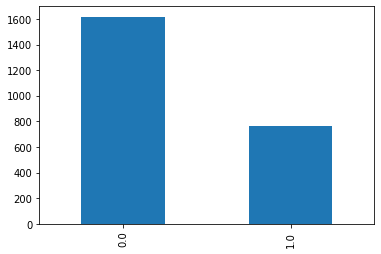

In [10]:
train_unique['current_working_status'].value_counts().plot.bar()

The count of employees who have left (represented as 0) is almost double as compared to the employees who are still working (represented as 1).

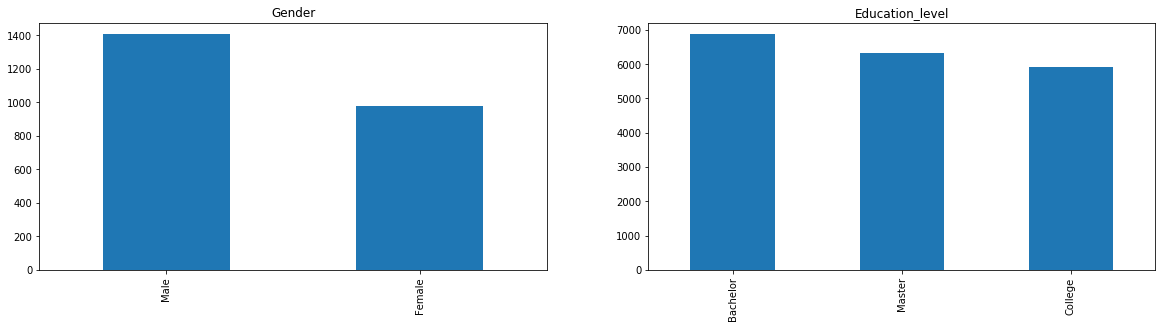

In [11]:
plt.figure(1)   
plt.subplot(221)
train_unique['Gender'].value_counts().plot.bar(figsize=(20,10),title='Gender')
plt.subplot(222)
train['Education_Level'].value_counts().plot.bar(figsize=(20,10),title='Education_level')
plt.show()

The company has more males than females. Most employees have an education level of Bachelor, followed by Master and college.

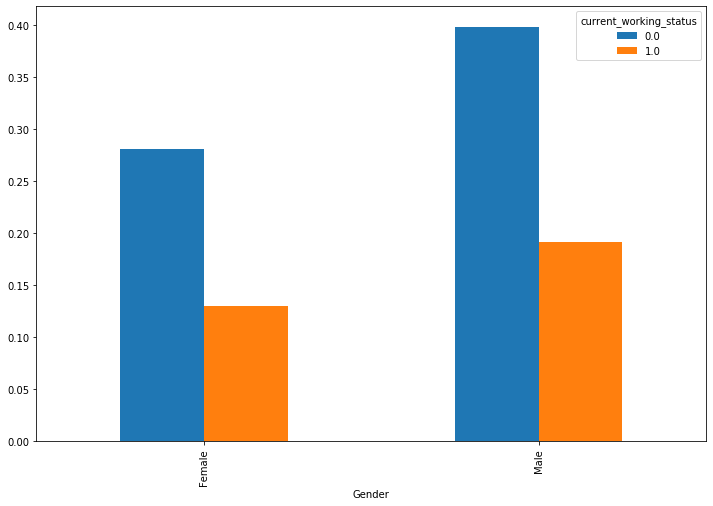

In [12]:
pd.crosstab(train_unique['Gender'],train_unique['current_working_status'],normalize=True).plot.bar(figsize=(12,8))

More percentage of males have left the company as compared to females

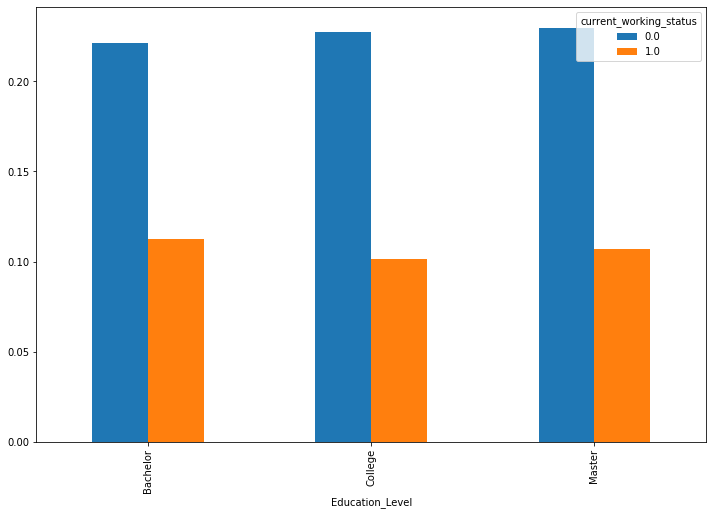

In [13]:
pd.crosstab(train_unique['Education_Level'],train_unique['current_working_status'],normalize=True).plot.bar(figsize=(12,8))

No specific trend observed in Educated Level with respect to attrition.

In [14]:
#merging train with aggregate business values
train_unique=train_unique.drop(['Total Business Value'],axis=1)
train_unique=train_unique.merge(business_value,on='Emp_ID')
train_unique.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Quarterly Rating,current_working_status,Total Business Value
0,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,2,0.0,571860.0
1,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,1,1.0,0.0
2,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,1,0.0,70000.0
3,2016-03-01,5,29,Male,C9,College,46368,2016-01-09,2016-03-07,1,1,1,0.0,40120.0
4,2017-12-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,2,1.0,253000.0


In [15]:
#renaming column name 'Total Business Value' to 'Average Business Value'
train_unique = train_unique.rename(columns={'Total Business Value':'Average Business Value'})
train_unique.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Quarterly Rating,current_working_status,Average Business Value
0,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,2,0.0,571860.0
1,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,1,1.0,0.0
2,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,1,0.0,70000.0
3,2016-03-01,5,29,Male,C9,College,46368,2016-01-09,2016-03-07,1,1,1,0.0,40120.0
4,2017-12-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,2,1.0,253000.0


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


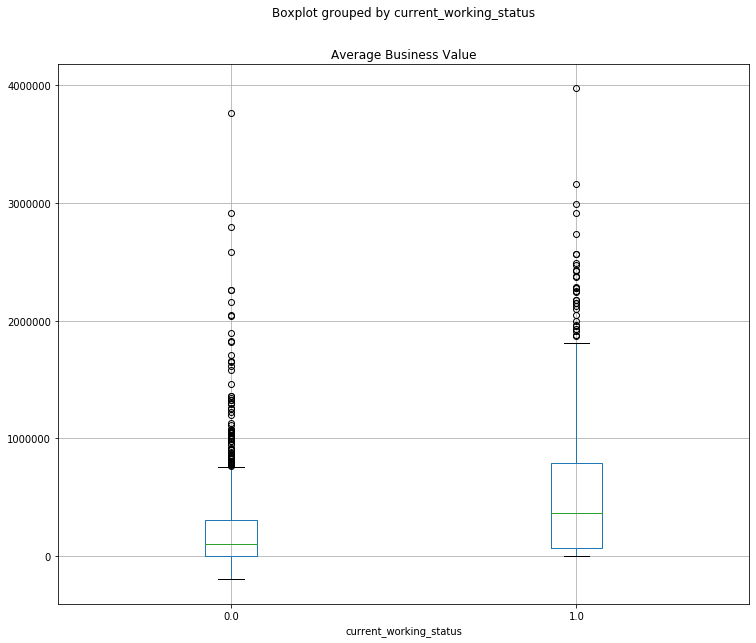

In [16]:
train_unique.boxplot('Average Business Value',by='current_working_status',figsize=(12,10))

The above box plots show the distribution of average business values. It can be clearly observed that the employees who are still working have a much higher average business value as compared to the employees who have left. Let's see if this has on impact on the employee ratings as well.

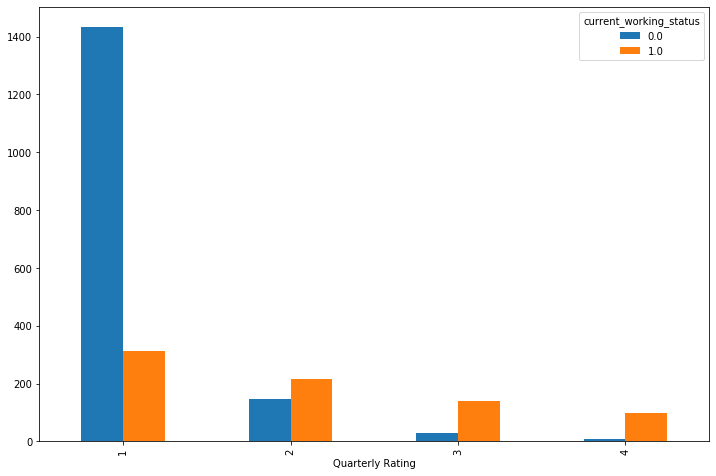

In [17]:
# plotting latest quarterly ratings
pd.crosstab(train_unique['Quarterly Rating'],train_unique['current_working_status']).plot.bar(figsize=(12,8))

As depicted by the above chart, the employees having the lowest rating i.e. 1, have the highest attrition as compared to other rating categories.

Let us observe the performance of employees in the latest quarter (last 3 months) by calculating the average of business value.

In [18]:
#converting to datetype datatype
import datetime as dt
train['Dateofjoining']= pd.to_datetime(train['Dateofjoining'])
train['LastWorkingDate']= pd.to_datetime(train['LastWorkingDate'])
train['MMM-YY']= pd.to_datetime(train['MMM-YY'])

In [19]:
#creating a recency rank for each record of an employee based on reporting date 'MMM-YY'
train = train.sort_values(by=["Emp_ID", "MMM-YY"],ascending = [True,False])
train['recency_rank']=train.groupby('Emp_ID')['MMM-YY'].rank(ascending=False)
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,recency_rank
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,1.0
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2,2.0
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2,3.0
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,1.0
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,2.0


In [20]:
#calculating business value for the latest 3 months for each employee
latest_business_value = train.where(train['recency_rank']<=3).groupby('Emp_ID').agg({'Total Business Value':'mean'})
train_unique = train_unique.merge(latest_business_value,on='Emp_ID')
train_unique = train_unique.rename(columns={'Total Business Value':'Latest Business Value'})
train_unique.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Quarterly Rating,current_working_status,Average Business Value,Latest Business Value
0,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,2,0.0,571860.0,571860.000000
1,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,1,1.0,0.0,0.000000
2,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,1,0.0,70000.0,116666.666667
3,2016-03-01,5,29,Male,C9,College,46368,2016-01-09,2016-03-07,1,1,1,0.0,40120.0,40120.000000
4,2017-12-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,2,1.0,253000.0,421666.666667


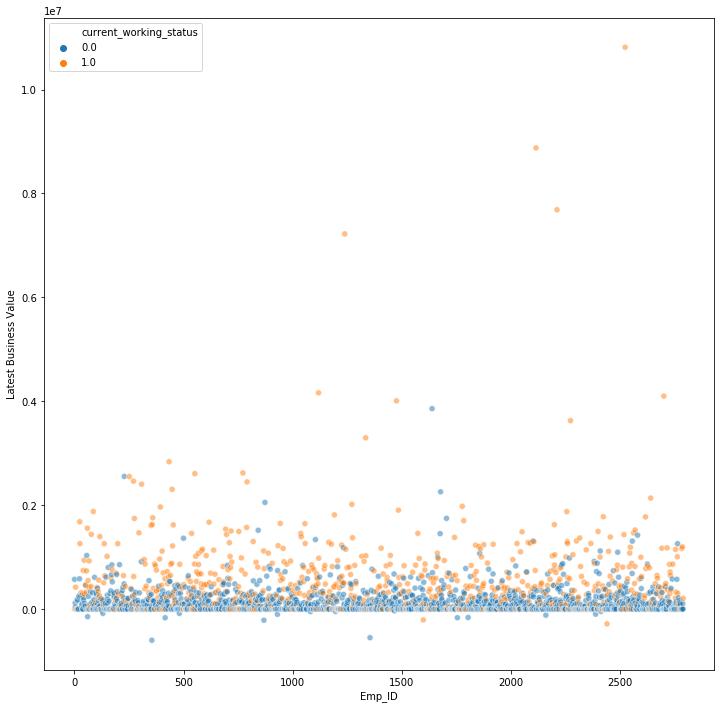

In [21]:
plt.figure(figsize=(12,12))
sns.scatterplot(data = train_unique,x = 'Emp_ID',y = 'Latest Business Value',alpha=0.5,hue='current_working_status')

As we can see from the above chart, the employees who have left (blue dots) have lower latest business value as compared to employees who are still working.
To have a clearer view, let's eliminate high business values (> 50,000,00) and plot the chart again.

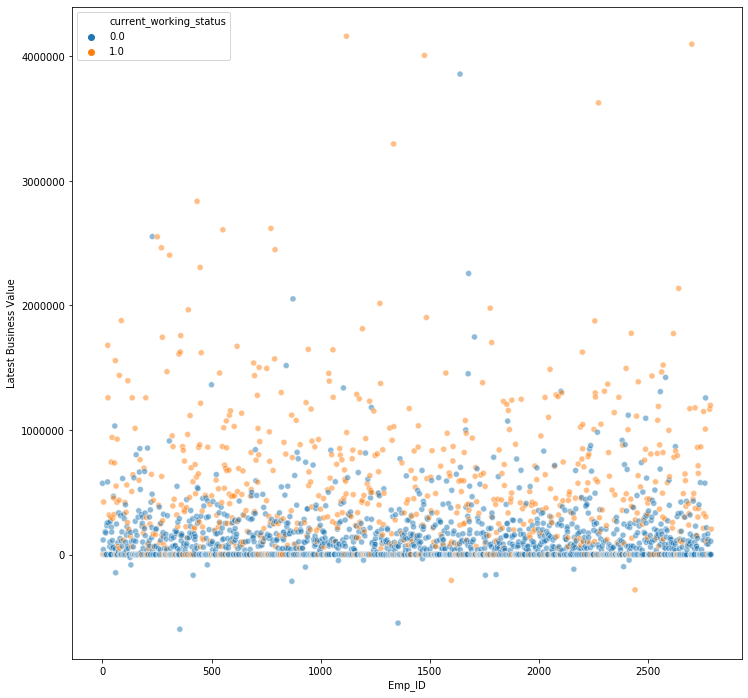

In [22]:
plt.figure(figsize=(12,12))
sns.scatterplot(data = train_unique[train_unique['Latest Business Value']<5000000],
                x = 'Emp_ID',y = 'Latest Business Value',alpha=0.5,hue='current_working_status')

Let us observe the impact of promotions on attrition. We will create a new column for the same.

In [23]:
#calculating difference between joining designation and designation
train_unique['promotions']=train_unique['Designation'] - train_unique['Joining Designation']

In [24]:
#dropping joining designation and designation
train_unique = train_unique.drop(['Joining Designation','Designation'],axis=1)

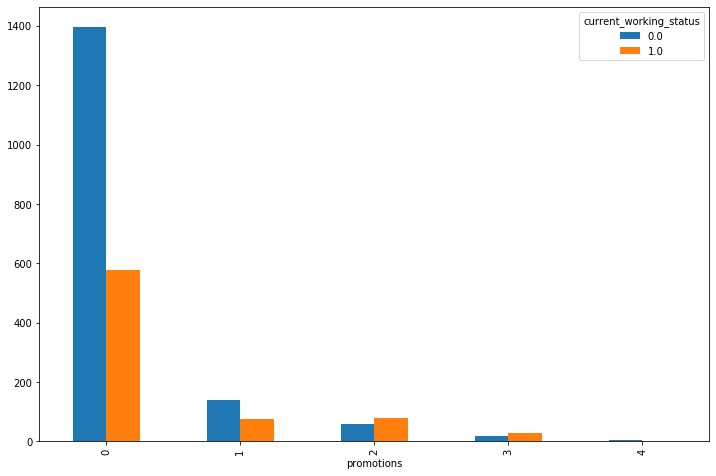

In [56]:
# plotting latest quarterly ratings
pd.crosstab(train_unique['promotions'],train_unique['current_working_status']).plot.bar(figsize=(12,8))

We can see that most of the employees who have left the firm had 0 promotions.

Let us observe the impact of tenure (in months) on attrition. We will create a new column for the same.

In [26]:
#calculating tenure in months for each employee
months = train.groupby('Emp_ID')['MMM-YY'].count()
months = months.rename('tenure')
train_unique = train_unique.merge(months, on = 'Emp_ID')
train_unique.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Quarterly Rating,current_working_status,Average Business Value,Latest Business Value,promotions,tenure
0,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,2,0.0,571860.0,571860.000000,0,3
1,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,1,1.0,0.0,0.000000,0,2
2,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,1,0.0,70000.0,116666.666667,0,5
3,2016-03-01,5,29,Male,C9,College,46368,2016-01-09,2016-03-07,1,0.0,40120.0,40120.000000,0,3
4,2017-12-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,2,1.0,253000.0,421666.666667,0,5


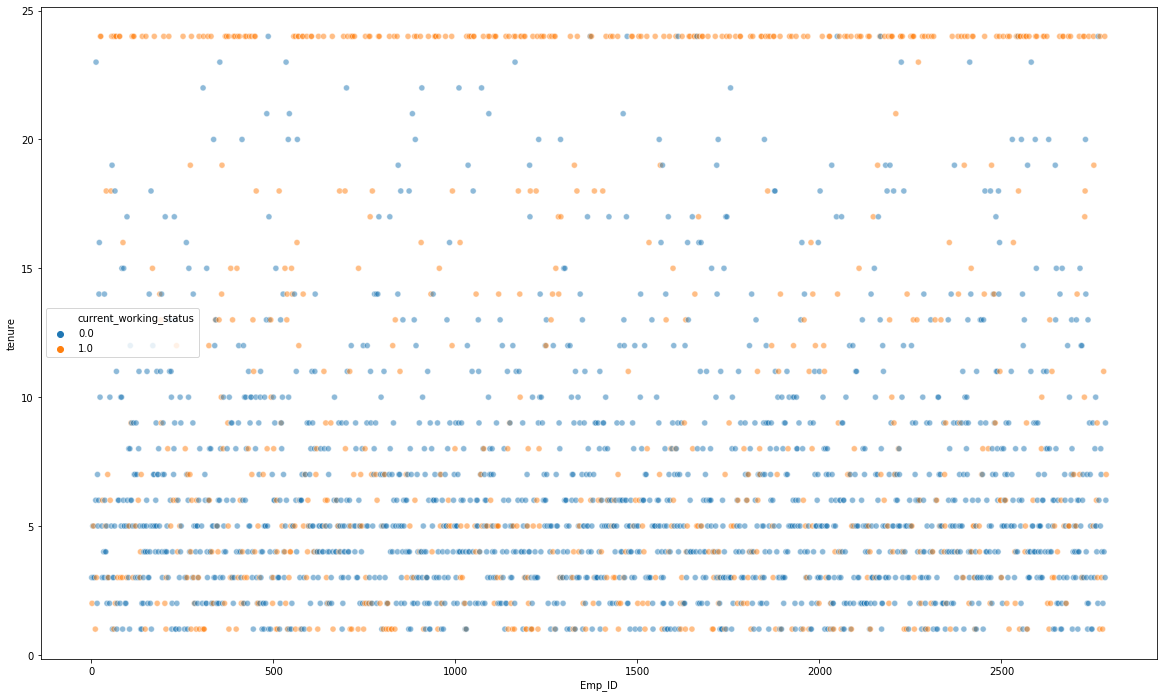

In [27]:
plt.figure(figsize=(20,12))
sns.scatterplot(data = train_unique,x = 'Emp_ID',y = 'tenure',alpha=0.5,hue='current_working_status')

In [28]:
#dropping columns which are not required
train_unique=train_unique.drop(['MMM-YY','Dateofjoining','LastWorkingDate'], axis=1)

In [29]:
#converting gender to categorical data type
train_unique['Gender']=train_unique['Gender'].astype('category')
train_unique['Gender']=train_unique['Gender'].cat.codes

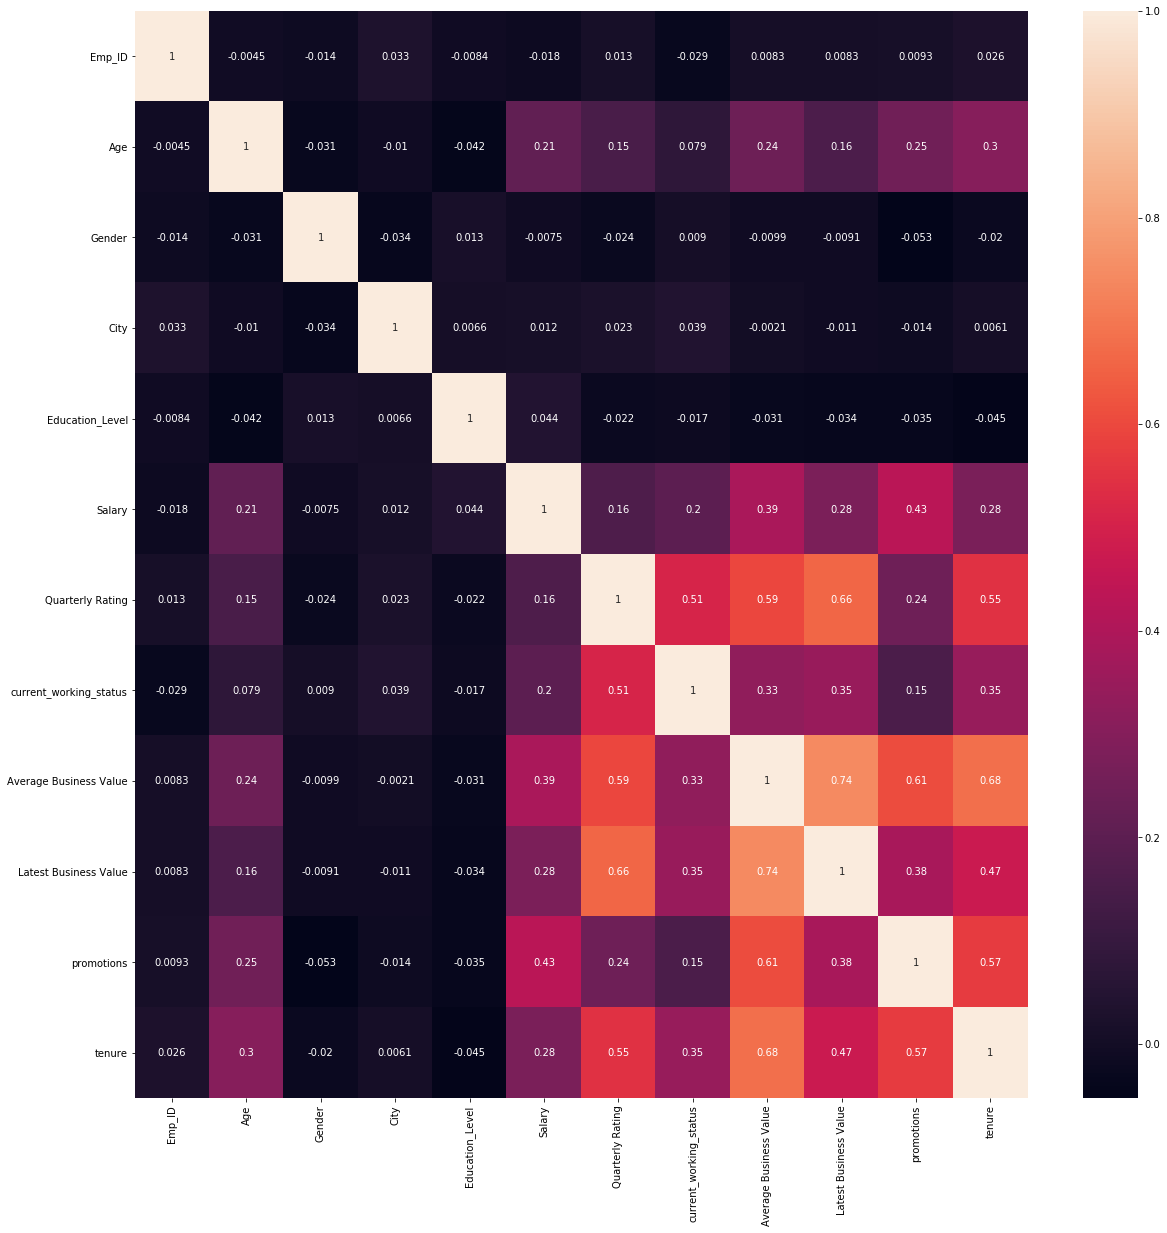

In [30]:
#checking correlation amongst all variables
train_temp=train_unique.copy()
train_temp['City']=train_temp['City'].astype('category')
train_temp['City']=train_temp['City'].cat.codes
train_temp['Education_Level']=train_temp['Education_Level'].astype('category')
train_temp['Education_Level']=train_temp['Education_Level'].cat.codes
plt.figure(figsize = (20,20))
sns.heatmap(train_temp.corr(), annot=True)

Quarterly rating, Average Business Value, Latest business value and tenure have the highest correlation with the current working status of an employee.

In [31]:
#encoding categorical variables
train_unique = pd.get_dummies(train_unique, columns=['City', 'Education_Level'])

In [32]:
train_unique.head()

,Emp_ID,Age,Gender,Salary,Quarterly Rating,current_working_status,Average Business Value,Latest Business Value,promotions,tenure,...,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Education_Level_Bachelor,Education_Level_College,Education_Level_Master
0,1,28,1,57387,2,0.0,571860.0,571860.000000,0,3,...,0,0,0,0,0,0,0,0,0,1
1,2,31,1,67016,1,1.0,0.0,0.000000,0,2,...,0,0,0,0,1,0,0,0,0,1
2,4,43,1,65603,1,0.0,70000.0,116666.666667,0,5,...,0,0,0,0,0,0,0,0,0,1
3,5,29,1,46368,1,0.0,40120.0,40120.000000,0,3,...,0,0,0,0,0,0,1,0,1,0
4,6,31,0,78728,2,1.0,253000.0,421666.666667,0,5,...,0,0,0,0,0,0,0,1,0,0


In [33]:
#completing the test dataset
test = test.merge(train_unique, on='Emp_ID')
test = test.drop('current_working_status',axis=1)

In [34]:
test.head()

,Emp_ID,Age,Gender,Salary,Quarterly Rating,Average Business Value,Latest Business Value,promotions,tenure,City_C1,...,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Education_Level_Bachelor,Education_Level_College,Education_Level_Master
0,394,34,0,97722,3,1.144092e+06,1.964797e+06,2,24,0,...,0,0,0,0,0,0,0,0,0,1
1,173,39,1,56174,3,8.277621e+05,7.610500e+05,2,24,0,...,0,0,0,0,0,0,0,0,1,0
2,1090,39,1,96750,2,2.099270e+06,7.984967e+05,2,24,0,...,0,0,0,0,0,0,0,0,1,0
3,840,40,0,88813,2,7.139183e+05,8.066700e+05,3,24,0,...,0,0,0,0,0,1,0,0,1,0
4,308,32,1,188418,2,2.417687e+06,2.403903e+06,3,24,0,...,0,0,1,0,0,0,0,0,0,1


In [35]:
#dropping EMP_ID from train
train_unique=train_unique.drop('Emp_ID',axis=1)
train_unique.head()

,Age,Gender,Salary,Quarterly Rating,current_working_status,Average Business Value,Latest Business Value,promotions,tenure,City_C1,...,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Education_Level_Bachelor,Education_Level_College,Education_Level_Master
0,28,1,57387,2,0.0,571860.0,571860.000000,0,3,0,...,0,0,0,0,0,0,0,0,0,1
1,31,1,67016,1,1.0,0.0,0.000000,0,2,0,...,0,0,0,0,1,0,0,0,0,1
2,43,1,65603,1,0.0,70000.0,116666.666667,0,5,0,...,0,0,0,0,0,0,0,0,0,1
3,29,1,46368,1,0.0,40120.0,40120.000000,0,3,0,...,0,0,0,0,0,0,1,0,1,0
4,31,0,78728,2,1.0,253000.0,421666.666667,0,5,0,...,0,0,0,0,0,0,0,1,0,0


# Modeling

In [36]:
#defining x and y
x = train_unique.drop('current_working_status',axis=1)
y = train_unique['current_working_status']

In [37]:
#splitting train data
x_train,x_eval,y_train,y_eval = train_test_split(x,y,test_size=0.3,shuffle=True)

In [38]:
# defining a function for model evaluation
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics
    
    # Predict Test Data 
    y_pred = model.predict(x_test)
    
    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

# Logistic Regression

In [75]:
# Building KNN Model
logistic = LogisticRegression()
logistic.fit(x_train, y_train)

LogisticRegression()

In [76]:
# Evaluate Model - KNN
logistic_eval = evaluate_model(logistic, x_eval, y_eval)
# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.73006993006993
Precision: 0.5976331360946746
Recall: 0.4469026548672566
F1 Score: 0.5113924050632911
Cohens Kappa Score: 0.33024165562496066
Area Under Curve: 0.704363248095264
Confusion Matrix:
 [[421  68]
 [125 101]]


# KNN

In [39]:
# Building KNN Model
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [40]:
# Evaluate Model - KNN
knn_eval = evaluate_model(knn, x_eval, y_eval)
# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.73006993006993
Precision: 0.5976331360946746
Recall: 0.4469026548672566
F1 Score: 0.5113924050632911
Cohens Kappa Score: 0.33024165562496066
Area Under Curve: 0.704363248095264
Confusion Matrix:
 [[421  68]
 [125 101]]


# Decision Tree

In [41]:
#building decision tree model
decision_tree= tree.DecisionTreeClassifier(random_state=0)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

In [42]:
# Evaluate Model - Random Forest
decision_tree_eval = evaluate_model(decision_tree, x_eval, y_eval)
# Print result
print('Accuracy:', decision_tree_eval['acc'])
print('Precision:', decision_tree_eval['prec'])
print('Recall:', decision_tree_eval['rec'])
print('F1 Score:', decision_tree_eval['f1'])
print('Cohens Kappa Score:', decision_tree_eval['kappa'])
print('Area Under Curve:', decision_tree_eval['auc'])
print('Confusion Matrix:\n', decision_tree_eval['cm'])

Accuracy: 0.7328671328671329
Precision: 0.5757575757575758
Recall: 0.588495575221239
F1 Score: 0.5820568927789935
Cohens Kappa Score: 0.3857913224162668
Area Under Curve: 0.6940432886331145
Confusion Matrix:
 [[391  98]
 [ 93 133]]


# Random Forest

In [43]:
#building random forest model
random_forest=RandomForestClassifier(random_state=10)
random_forest.fit(x_train,y_train)

RandomForestClassifier(random_state=10)

In [44]:
# Evaluate Model - Random Forest
random_forest_eval = evaluate_model(knn, x_eval, y_eval)
# Print result
print('Accuracy:', random_forest_eval['acc'])
print('Precision:', random_forest_eval['prec'])
print('Recall:', random_forest_eval['rec'])
print('F1 Score:', random_forest_eval['f1'])
print('Cohens Kappa Score:', random_forest_eval['kappa'])
print('Area Under Curve:', random_forest_eval['auc'])
print('Confusion Matrix:\n', random_forest_eval['cm'])

Accuracy: 0.73006993006993
Precision: 0.5976331360946746
Recall: 0.4469026548672566
F1 Score: 0.5113924050632911
Cohens Kappa Score: 0.33024165562496066
Area Under Curve: 0.704363248095264
Confusion Matrix:
 [[421  68]
 [125 101]]


# Naive Bayes

In [45]:
#building random forest model
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

In [46]:
# Evaluate Model - Random Forest
nb_eval = evaluate_model(nb, x_eval, y_eval)
# Print result
print('Accuracy:', nb_eval['acc'])
print('Precision:', nb_eval['prec'])
print('Recall:', nb_eval['rec'])
print('F1 Score:', nb_eval['f1'])
print('Cohens Kappa Score:', nb_eval['kappa'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.7356643356643356
Precision: 0.6868686868686869
Recall: 0.3008849557522124
F1 Score: 0.41846153846153844
Cohens Kappa Score: 0.2797678372515682
Area Under Curve: 0.7094666739055684
Confusion Matrix:
 [[458  31]
 [158  68]]


# XG Boost

In [47]:
# building xg boost model
xgboost = XGBClassifier()
xgboost.fit(x_train, y_train)

XGBClassifier()

In [48]:
# Evaluate Model - XG Boost Classifier
xgboost_eval = evaluate_model(xgboost, x_eval, y_eval)
# Print result
print('Accuracy:', xgboost_eval['acc'])
print('Precision:', xgboost_eval['prec'])
print('Recall:', xgboost_eval['rec'])
print('F1 Score:', xgboost_eval['f1'])
print('Cohens Kappa Score:', xgboost_eval['kappa'])
print('Area Under Curve:', xgboost_eval['auc'])
print('Confusion Matrix:\n', xgboost_eval['cm'])

Accuracy: 0.8321678321678322
Precision: 0.8154761904761905
Recall: 0.6061946902654868
F1 Score: 0.6954314720812184
Cohens Kappa Score: 0.583037701556076
Area Under Curve: 0.8528286009012431
Confusion Matrix:
 [[458  31]
 [ 89 137]]


# Extra Trees Classifier

In [49]:
# building extra trees classifier model
extra_trees = ExtraTreesClassifier(n_estimators=100)
extra_trees.fit(x_train, y_train)

ExtraTreesClassifier()

In [50]:
# Evaluate Model - Extra Trees Classifier
extra_trees_eval = evaluate_model(extra_trees, x_eval, y_eval)
# Print result
print('Accuracy:', extra_trees_eval['acc'])
print('Precision:', extra_trees_eval['prec'])
print('Recall:', extra_trees_eval['rec'])
print('F1 Score:', extra_trees_eval['f1'])
print('Cohens Kappa Score:', extra_trees_eval['kappa'])
print('Area Under Curve:', extra_trees_eval['auc'])
print('Confusion Matrix:\n', extra_trees_eval['cm'])

Accuracy: 0.8195804195804196
Precision: 0.793939393939394
Recall: 0.5796460176991151
F1 Score: 0.6700767263427111
Cohens Kappa Score: 0.5500402468473302
Area Under Curve: 0.8359483866297482
Confusion Matrix:
 [[455  34]
 [ 95 131]]


# Cat Boost Classifier

In [65]:
# building cat boost model
cat = CatBoostClassifier(iterations=5)
cat.fit(x_train, y_train)

Learning rate set to 0.5
0:	learn: 0.4847239	total: 52.6ms	remaining: 211ms
1:	learn: 0.4322325	total: 54.3ms	remaining: 81.5ms
2:	learn: 0.4007188	total: 56ms	remaining: 37.3ms
3:	learn: 0.3794250	total: 57.8ms	remaining: 14.4ms
4:	learn: 0.3680282	total: 60.2ms	remaining: 0us


In [66]:
# Evaluate Model - Cat Boost Classifier
cat_eval = evaluate_model(cat, x_eval, y_eval)
# Print result
print('Accuracy:', extra_trees_eval['acc'])
print('Precision:', extra_trees_eval['prec'])
print('Recall:', extra_trees_eval['rec'])
print('F1 Score:', extra_trees_eval['f1'])
print('Cohens Kappa Score:', extra_trees_eval['kappa'])
print('Area Under Curve:', extra_trees_eval['auc'])
print('Confusion Matrix:\n', extra_trees_eval['cm'])

Accuracy: 0.8195804195804196
Precision: 0.793939393939394
Recall: 0.5796460176991151
F1 Score: 0.6700767263427111
Cohens Kappa Score: 0.5500402468473302
Area Under Curve: 0.8359483866297482
Confusion Matrix:
 [[455  34]
 [ 95 131]]


# Light GBM

In [68]:
# building light gbm model
lgbm = lgb.LGBMClassifier()
lgbm.fit(x_train, y_train)

LGBMClassifier()

In [71]:
# Evaluate Model - Light GBM
lgbm_eval = evaluate_model(lgbm, x_eval, y_eval)



# Print result
print('Accuracy:', lgbm_eval['acc'])
print('Precision:', lgbm_eval['prec'])
print('Recall:', lgbm_eval['rec'])
print('F1 Score:', lgbm_eval['f1'])
print('Cohens Kappa Score:', lgbm_eval['kappa'])
print('Area Under Curve:', lgbm_eval['auc'])
print('Confusion Matrix:\n', lgbm_eval['cm'])

Accuracy: 0.7972027972027972
Precision: 0.7098445595854922
Recall: 0.6061946902654868
F1 Score: 0.6539379474940334
Cohens Kappa Score: 0.5117707170742505
Area Under Curve: 0.8403007763722244
Confusion Matrix:
 [[433  56]
 [ 89 137]]


# Ada Boost

In [72]:
# building ada boost model
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [77]:
# Evaluate Model - Ada boost
ada_eval = evaluate_model(ada, x_eval, y_eval)



# Print result
print('Accuracy:', lgbm_eval['acc'])
print('Precision:', lgbm_eval['prec'])
print('Recall:', lgbm_eval['rec'])
print('F1 Score:', lgbm_eval['f1'])
print('Cohens Kappa Score:', lgbm_eval['kappa'])
print('Area Under Curve:', lgbm_eval['auc'])
print('Confusion Matrix:\n', lgbm_eval['cm'])

Accuracy: 0.806993006993007
Precision: 0.7588235294117647
Recall: 0.5707964601769911
F1 Score: 0.6515151515151515
Cohens Kappa Score: 0.5217159476490547
Area Under Curve: 0.8279629730169933
Confusion Matrix:
 [[448  41]
 [ 97 129]]


# Model Comparison

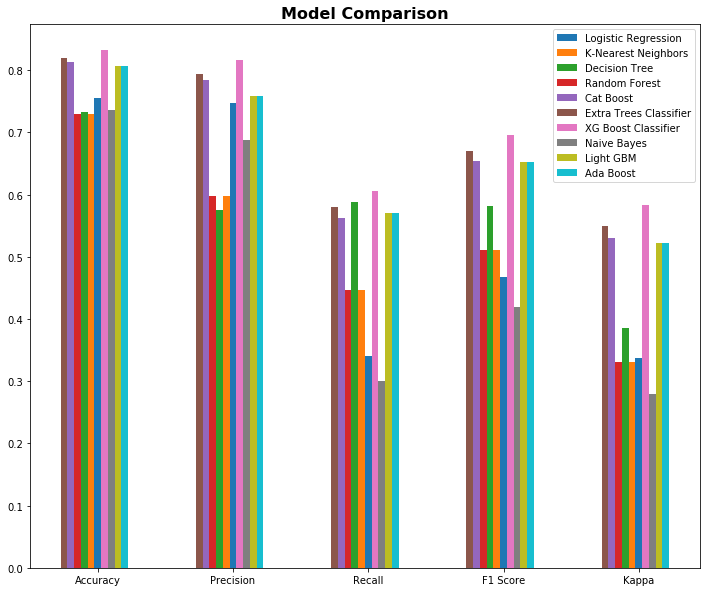

In [83]:
# Intitialize figure with two plots
plt.figure(figsize=(12,10))
plt.title('Model Comparison', fontsize=16, fontweight='bold')

decision_tree_score = [decision_tree_eval['acc'], decision_tree_eval['prec'], decision_tree_eval['rec'], decision_tree_eval['f1'], decision_tree_eval['kappa']]
random_forest_score = [random_forest_eval['acc'], random_forest_eval['prec'], random_forest_eval['rec'], random_forest_eval['f1'], random_forest_eval['kappa']]
xgboost_score = [xgboost_eval['acc'], xgboost_eval['prec'], xgboost_eval['rec'], xgboost_eval['f1'], xgboost_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]
logistic_score = [logistic_eval['acc'], logistic_eval['prec'], logistic_eval['rec'], logistic_eval['f1'], logistic_eval['kappa']]
lgbm_score = [lgbm_eval['acc'], lgbm_eval['prec'], lgbm_eval['rec'], lgbm_eval['f1'], lgbm_eval['kappa']]
ada_score = [ada_eval['acc'], ada_eval['prec'], ada_eval['rec'], ada_eval['f1'], ada_eval['kappa']]
cat_score = [cat_eval['acc'], cat_eval['prec'], cat_eval['rec'], cat_eval['f1'], cat_eval['kappa']]
extra_trees_score = [extra_trees_eval['acc'], extra_trees_eval['prec'], extra_trees_eval['rec'], extra_trees_eval['f1'], extra_trees_eval['kappa']]

x_labels = ['Accuracy','Precision','Recall','F1 Score','Kappa']
x_axis = 2*np.arange(len(x_labels))

## Make the plot
plt.bar(x_axis,logistic_score, label='Logistic Regression',width=0.1)
plt.bar(x_axis-0.1,knn_score, label='K-Nearest Neighbors',width=0.1)
plt.bar(x_axis-0.2,decision_tree_score, label='Decision Tree',width=0.1)
plt.bar(x_axis-0.3,random_forest_score, label='Random Forest',width=0.1)
plt.bar(x_axis-0.4,cat_score, label='Cat Boost',width=0.1)
plt.bar(x_axis-0.5,extra_trees_score, label='Extra Trees Classifier',width=0.1)
plt.bar(x_axis+0.1,xgboost_score, label='XG Boost Classifier',width=0.1)
plt.bar(x_axis+0.2,nb_score, label='Naive Bayes',width=0.1)
plt.bar(x_axis+0.3,lgbm_score, label='Light GBM',width=0.1)
plt.bar(x_axis+0.4,ada_score, label='Ada Boost',width=0.1)
plt.xticks(x_axis, x_labels)
plt.legend()

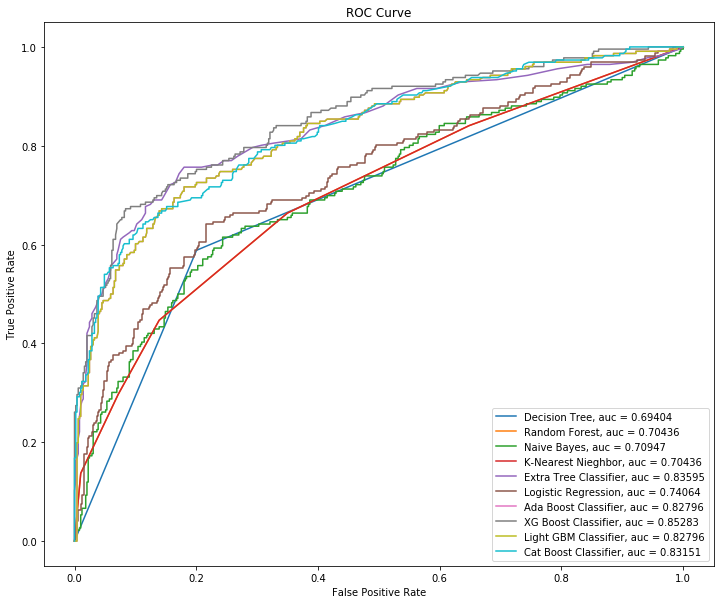

In [85]:
plt.figure(figsize=(12,10))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(decision_tree_eval['fpr'], decision_tree_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(decision_tree_eval['auc']))
plt.plot(random_forest_eval['fpr'], random_forest_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(random_forest_eval['auc']))
plt.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
plt.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))
plt.plot(extra_trees_eval['fpr'], extra_trees_eval['tpr'], label='Extra Tree Classifier, auc = {:0.5f}'.format(extra_trees_eval['auc']))
plt.plot(logistic_eval['fpr'], logistic_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(logistic_eval['auc']))
plt.plot(ada_eval['fpr'], ada_eval['tpr'], label='Ada Boost Classifier, auc = {:0.5f}'.format(ada_eval['auc']))
plt.plot(xgboost_eval['fpr'], xgboost_eval['tpr'], label='XG Boost Classifier, auc = {:0.5f}'.format(xgboost_eval['auc']))
plt.plot(lgbm_eval['fpr'], lgbm_eval['tpr'], label='Light GBM Classifier, auc = {:0.5f}'.format(lgbm_eval['auc']))
plt.plot(cat_eval['fpr'], cat_eval['tpr'], label='Cat Boost Classifier, auc = {:0.5f}'.format(cat_eval['auc']))
plt.legend()


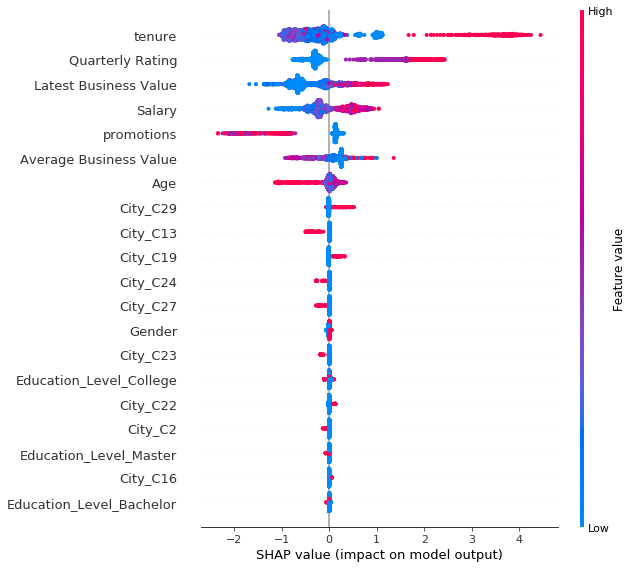

In [53]:
#shap.initjs()
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)

In [58]:
train_unique['City_C5'].value_counts()

0    2301
1      80
Name: City_C5, dtype: int64

In [54]:
dkjnsc
model.score(x_eval,y_eval)

NameError: name 'dkjnsc' is not defined

In [ ]:
from sklearn import metrics
metrics.f1_score(y_eval,model.predict(x_eval))

In [ ]:
model.predict(x_eval)

In [ ]:
test.head()

In [ ]:
###run till here
sdks

In [ ]:
#creating new test dataset by dropping EMP_ID
test_new=test.drop('Emp_ID',axis=1)

In [ ]:
#applying scaling on test data
test_new=scaler.transform(test_new)

In [ ]:
#predicting target for test data
test_pred = model.predict(test_new)

In [ ]:
output = pd.DataFrame({'Emp_ID':test['Emp_ID'],'Target':test_pred})

In [ ]:
output['Target'].value_counts()

In [ ]:
output.to_csv('/Users/Rajesh/Documents/Master Plan/Jobathon Nov 21/output.csv',index=False)

# Hyperparameter Tuning

In [ ]:
#printing the parameters in use
print('Parameters currently in use:\n')
print(model.get_params())

### Random Search Cross Validation

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [ ]:
#printing the best parameter combination
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
#evaluating performance
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_train, y_train)

In [ ]:
best_random.score(x_eval,y_eval)

In [ ]:
#f1 score
metrics.f1_score(y_eval,best_random.predict(x_eval))

In [ ]:
#predicting target for test file
test_pred = best_random.predict(test_new)

In [ ]:
output = pd.DataFrame({'Emp_ID':test['Emp_ID'],'Target':test_pred})
output.to_csv('/Users/Rajesh/Documents/Master Plan/Jobathon Nov 21/output.csv',index=False)